In [2]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

In [3]:
from NN import *
from utils import get_tf_session
from data_utils import make_batch, single_np_datapoint_generator

import tensorflow as tf
import matplotlib.pyplot as plt
import time

In [4]:
train_dataset_files = [
 './data/tfrecords/0.tfrecord',
 './data/tfrecords/1.tfrecord',
 './data/tfrecords/2.tfrecord',
 './data/tfrecords/3.tfrecord',
 './data/tfrecords/4.tfrecord',
 './data/tfrecords/5.tfrecord',
 './data/tfrecords/6.tfrecord',
 './data/tfrecords/7.tfrecord',
 './data/tfrecords/8.tfrecord',
]

validation_dataset_files = ['./data/tfrecords/9.tfrecord']

In [5]:
X_batch, Y_batch = make_batch(train_dataset_files, 200)
loss_weights = tf.placeholder(dtype=tf.float32, shape=(6,))
no_of_filter_fns=[
    lambda i: 0 if i == 0 else 11 + 3 * (i - 1), 
    lambda i: 10 + 3 * i
]
train_op, loss = create_yolo_model_graph(X_batch, Y_batch, no_of_filter_fns, loss_weights)
X = tf.placeholder(dtype=tf.float32, shape=(None, None, None, 3), name="Input")
layers, _, pred = get_yolo_NN(X, no_of_filter_fns)
chk_loc = './models/model_1.ckpt'

In [6]:
sess, saver = get_tf_session(chk_loc)
if tf.test.is_gpu_available():
    print("Tensorflow is able to detect gpu...")

INFO:tensorflow:Restoring parameters from ./models/model_with_increased_layer_checkpoint/model_1.ckpt
NOTE: restored variables from checkpoint file!
Tensorflow is able to detect gpu...


In [ ]:
avg_loss = 0
print_int = 200
save_int = 1000
st = time.time()
for i in range(5000):
    _, loss_value= sess.run([train_op, loss], feed_dict={loss_weights: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]})
    avg_loss += loss_value
    if i>0 and i%print_int == 0:
        print("Batch No.", i, "Avg loss:", avg_loss/print_int)
        avg_loss = 0
    if i>0 and i%save_int == 0:
        print("Model saved in path: %s" % saver.save(sess, chk_loc))
print("Model saved in path: %s" % saver.save(sess, chk_loc))
print("training took total", time.time() - st, "seconds")

Batch No. 200 Avg loss: 4.287883715629578
Batch No. 400 Avg loss: 3.4223215448856354
Batch No. 600 Avg loss: 3.2090709507465363
Batch No. 800 Avg loss: 3.072827981710434
Batch No. 1000 Avg loss: 2.9372045695781708
Model saved in path: ./models/model_1.ckpt
Batch No. 1200 Avg loss: 2.833578885793686
Batch No. 1400 Avg loss: 2.7433802318572997
Batch No. 1600 Avg loss: 2.6727259969711303
Batch No. 1800 Avg loss: 2.610167759656906
Batch No. 2000 Avg loss: 2.5620234966278077
Model saved in path: ./models/model_1.ckpt
Batch No. 2200 Avg loss: 2.533413679599762
Batch No. 2400 Avg loss: 2.4812457954883573
Batch No. 2600 Avg loss: 2.4405893576145172
Batch No. 2800 Avg loss: 2.4127490055561065
Batch No. 3000 Avg loss: 2.390082508325577
Model saved in path: ./models/model_1.ckpt
Batch No. 3200 Avg loss: 2.378494507074356
Batch No. 3400 Avg loss: 2.3589999961853025
Batch No. 3600 Avg loss: 2.344456000328064
Batch No. 3800 Avg loss: 2.338793898820877
Batch No. 4000 Avg loss: 2.3348535668849943
Mode

In [6]:
print(calculate_yolo_metric(sess, X, pred, validation_dataset_files))

Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images
Processed 500 images
Processed 600 images
Processed 700 images
Processed 800 images
Processed 900 images
Processed 1000 images
Processed 1100 images
Processed 1200 images
Processed 1300 images
Processed 1400 images
Processed 1500 images
Processed 1503 images
{'total_count': 1503, 'average_iou': 0.6337394810322717, 'average_false_iou': 0.6145007259427673, 'gender_accuracy': 0.7811044577511643, 'age_accuracy': 0.3413173652694611}


In [ ]:
gen = single_np_datapoint_generator(validation_dataset_files)

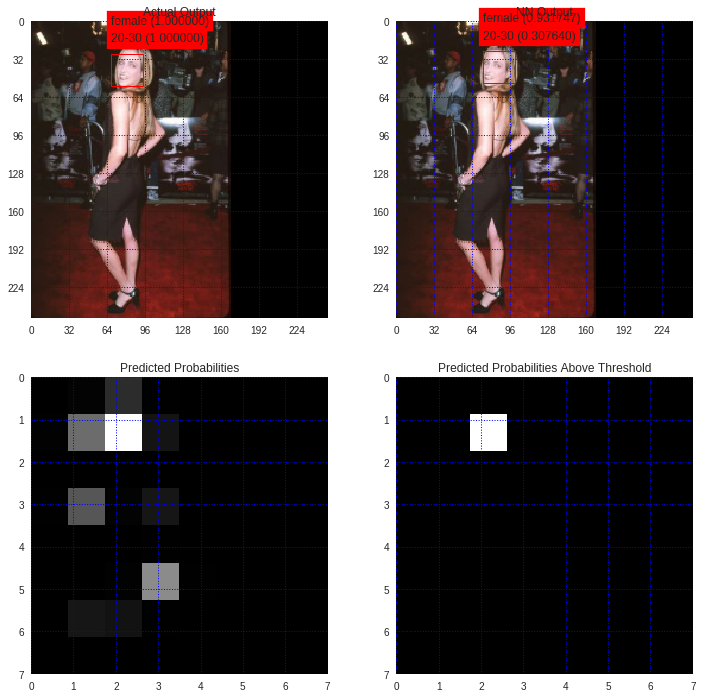

In [8]:
img, out = next(gen)
see_and_compare_yolo_outputs(sess, X, pred, img, out)

In [7]:
gen = single_np_datapoint_generator(validation_dataset_files)
batch_size = 100
print("Reading images")
img_gen = group_iterable_into_list(gen, batch_size, 2)
images, _ = next(img_gen)

print("Getting predictions")
st = time.time()
for imgs in group_iterable_into_list(images, 50):
    o = sess.run([pred], feed_dict={X: imgs})
total_time = time.time()-st

print("Processing", batch_size, "images took", total_time, "seconds.")
print("Average rate is", batch_size/total_time, "images per second.")

img_gen.close()
gen.close()

Reading images
Getting predictions
Processing 100 images took 2.5278842449188232 seconds.
Average rate is 39.55877338964596 images per second.


In [ ]:
tf.saved_model.simple_save(sess, './models/yolo_saved_model', 
                           inputs={"x": X}, 
                           outputs={"pred": tf.identity(pred, name="Output")})